![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

#Transfer Learning con la técnica de Fine Tuning

# Connectar a Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librerias

In [2]:
from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model, load_model

# Variables de entorno

<font color="#FF0000">Aquí definireis vuestra ruta del proyecto de perros y Gatos</font>

In [3]:
ANCHO_IMAGEN = 150
ALTURA_IMAGEN=150
IMAGE_SIZE = (ANCHO_IMAGEN, ALTURA_IMAGEN)
CANALES_IMAGENES = 3

ruta_archivos = '/content/drive/My Drive/Nuclio_DS_Master/Dogs-vs-cats/'

# Cargaremos datos en NPZ


In [4]:
dict_npz = np.load(ruta_archivos+'xy_train_img.npz')
x_train_img = dict_npz['x']
y_train_img = dict_npz['y']

dict_npz = np.load(ruta_archivos+'xy_test_img.npz')
x_test_img = dict_npz['x']
y_test_img = dict_npz['y']

dict_npz = np.load(ruta_archivos+'xy_val_img.npz')
x_val_img = dict_npz['x']
y_val_img = dict_npz['y']

In [5]:
x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.
x_val_scaled = x_val_img / 255.

# Montamos la Red Neuronal

## Cargar la parte de extraccion de features de VGG16

In [6]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(ANCHO_IMAGEN, ALTURA_IMAGEN, CANALES_IMAGENES))

In [7]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [8]:
output = vgg.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
vgg_model = Model(vgg.input, new_output_layer)

In [9]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [10]:
vgg_model.trainable = True #Abrimos la opción a que se puedan modificar pesos del modelo

for layer in vgg_model.layers:
  layer.trainable = False

In [11]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe2711380b8>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe271139048>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe23758c978>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe2375e6128>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe2375b7d68>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe2375e3208>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe23762a550>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe23e4edfd0>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe23e4e0be0>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe23762a978>,block3_conv3,False


In [12]:
entrenable = False

for layer in vgg_model.layers:
  if layer.name in ['block5_conv1','block4_conv1']:
    entrenable = True
  if entrenable:
    layer.trainable = True
  else: 
    layer.trainable = False

In [13]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe2711380b8>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe271139048>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe23758c978>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe2375e6128>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe2375b7d68>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe2375e3208>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe23762a550>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe23e4edfd0>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe23e4e0be0>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe23762a978>,block3_conv3,False


# Montemos la red de VGG16 + Clasificación


In [14]:
input_shape = vgg_model.output_shape[1]

print('Tamaño de entrada:', input_shape)

Tamaño de entrada: 8192


In [15]:
model_with_vgg = ks.Sequential()

model_with_vgg.add(vgg_model)
model_with_vgg.add(ks.layers.Dense(512, activation='relu', input_shape=(input_shape,)))
model_with_vgg.add(ks.layers.Dropout(0.3))
model_with_vgg.add(ks.layers.Dense(512, activation='relu'))
model_with_vgg.add(ks.layers.Dropout(0.3))
model_with_vgg.add(ks.layers.Dense(1, activation='sigmoid'))

model_with_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 8192)              14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
____________________________________

# Creamos un optimizador

In [16]:
from tensorflow.keras.optimizers import Adam

In [17]:
new_adam = Adam(learning_rate=2e-5)


In [18]:
model_with_vgg.compile(loss='binary_crossentropy', optimizer=new_adam, metrics=['accuracy'])

# Early stopping!!

In [19]:
callback = EarlyStopping(monitor='val_loss', patience=5)

# Encoding de etiquetas

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [21]:
print(np.array(y_train_img))
print(np.array(y_train_encoded))

y_train_encoded

['dog' 'cat' 'dog' ... 'dog' 'dog' 'cat']
[1 0 1 ... 1 1 0]


array([1, 0, 1, ..., 1, 1, 0])

## Data Augmentation

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
    )

train_generator = train_datagen.flow(
    x_train_img, 
    y_train_encoded, 
    batch_size=30
)

In [23]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val_img, 
    y_val_encoded, 
    batch_size=20
)

test_datagen = ImageDataGenerator(
    rescale=1./255
    )
test_generator = test_datagen.flow(
    x_test_img, 
    y_test_encoded,
    batch_size=20
)

# Entrenar

In [24]:
history = model_with_vgg.fit(train_generator, epochs=200, steps_per_epoch=98,
                             callbacks=[callback], 
                             validation_data=validation_generator, validation_steps=49)

Epoch 1/200
98/98 [==============================] - 26s 227ms/step - loss: 0.6696 - accuracy: 0.5751 - val_loss: 0.2718 - val_accuracy: 0.8929
Epoch 2/200
98/98 [==============================] - 21s 209ms/step - loss: 0.3731 - accuracy: 0.8420 - val_loss: 0.2213 - val_accuracy: 0.9010
Epoch 3/200
98/98 [==============================] - 21s 209ms/step - loss: 0.3279 - accuracy: 0.8554 - val_loss: 0.1651 - val_accuracy: 0.9439
Epoch 4/200
98/98 [==============================] - 21s 211ms/step - loss: 0.2427 - accuracy: 0.8913 - val_loss: 0.1542 - val_accuracy: 0.9429
Epoch 5/200
98/98 [==============================] - 21s 211ms/step - loss: 0.1978 - accuracy: 0.9197 - val_loss: 0.1678 - val_accuracy: 0.9347
Epoch 6/200
98/98 [==============================] - 21s 210ms/step - loss: 0.1847 - accuracy: 0.9269 - val_loss: 0.1896 - val_accuracy: 0.9378
Epoch 7/200
98/98 [==============================] - 21s 210ms/step - loss: 0.1832 - accuracy: 0.9256 - val_loss: 0.1412 - val_accuracy:

# Guardamos el modelo


In [25]:
model_with_vgg.save(ruta_archivos+"model_with_finetunning_transfer_learning_vgg16_plus_data_augmentation.h5")

# Carguemos el modelo con  Transfer Learning sin data augmentation

Aquí recogeremos el modelo y los datos de XY pasados por VGG16 post procesados guardados en NPZ

In [26]:
model_vgg16_fine_tuning = load_model(ruta_archivos+"model_with_finetunning_transfer_learning_vgg16.h5")


# Miremos que tal rinde el modelo en errores y accuracy

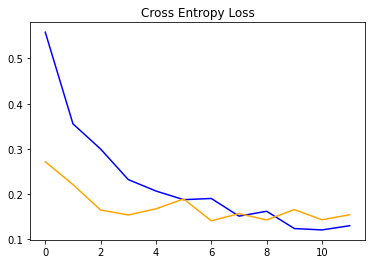

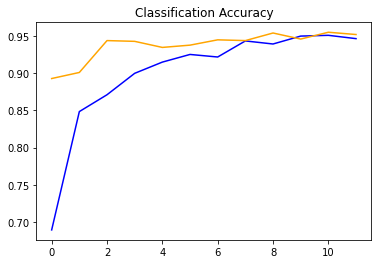

In [27]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

In [28]:
_, acc = model_with_vgg.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Modelo con Fine Tunning Transfer Learning con Data Augmentation> %.3f' % (acc * 100.0))

_, acc = model_vgg16_fine_tuning.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Modelo con Fine Tuning Transfer Learning sin Data Augmentaion> %.3f' % (acc * 100.0))

Modelo con Fine Tunning Transfer Learning con Data Augmentation> 94.843
Modelo con Fine Tuning Transfer Learning sin Data Augmentaion> 94.641
